In [1]:
import torch, random, os, multiprocessing
import torch.backends.cudnn as cudnn
from utils.model_res_double import generate_model
from torchsummary import summary
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
import monai
import numpy as np
from monai.data import CacheDataset, DataLoader, ImageDataset


In [2]:
dwi_dir =  './dataset/DWI_1-350/'
t1_dir = './dataset/T1_1-350/'

images = [{'dwi' : f'{os.path.join(dwi_dir, i[0])}' , 't1' : f'{os.path.join(t1_dir, i[1])}'} for i in zip(sorted(os.listdir(dwi_dir)), sorted(os.listdir(t1_dir)))]
# 2 binary labels for gender classification: man and woman
labels = np.array([0, 0, 0], dtype=np.int64)
print(images[10])

{'dwi': './dataset/DWI_1-350/is0011_dwi.nii.gz', 't1': './dataset/T1_1-350/is0011_T1.nii.gz'}


In [3]:
from monai.transforms import  LoadImageD, ScaleIntensityd, AddChannelD,  Compose
from monai.transforms import  AddChannel, RandAffined, RandRotated, RandZoomd, Rotate90d, Spacingd,AsChannelFirstd
loader = LoadImageD(keys=["dwi", "t1"], dtype=np.float32)
chage_shape = AsChannelFirstd(keys=["dwi", "t1"])
add_channel = AddChannelD(keys=["dwi", "t1"])


data_dict = loader(images[10])
print(data_dict['dwi'].shape, data_dict['t1'].shape)
data_dict = chage_shape(data_dict)
print(data_dict['dwi'].shape, data_dict['t1'].shape)
datac_dict = add_channel(data_dict)   # (1, 512, 512, 61)
print(data_dict['dwi'].shape, data_dict['t1'].shape)
trans = Compose([
                                    ScaleIntensityd(keys=['dwi', 't1'], maxv=1, minv=0),
                                    Rotate90d(keys=['t1','dwi'], spatial_axes=(1,2),k=1),
                                    RandRotated(keys=['dwi','t1'], mode=('bilinear', 'bilinear'), range_x=np.pi/30, prob=1.0),
                                    # RandAffined(keys=['dwi'], prob=1.0),
                                     ])
data_crop = trans(datac_dict)

(384, 384, 28) (512, 512, 28)
(28, 384, 384) (28, 512, 512)
(28, 384, 384) (28, 512, 512)


0.0 1.0
(28, 512, 512)


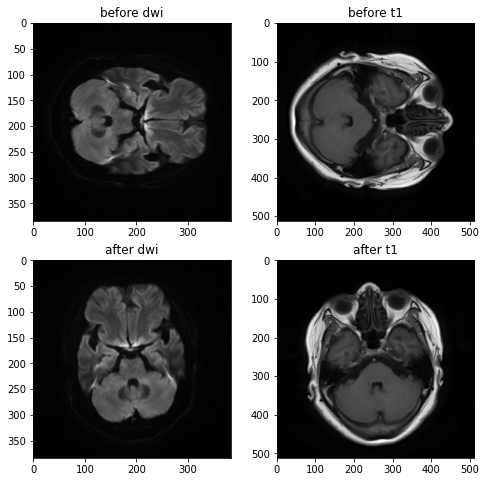

In [4]:
import matplotlib.pyplot as plt
image, label = datac_dict["dwi"][0], datac_dict["t1"][0]
imagecrop, labelcrop = data_crop["dwi"][0], data_crop["t1"][0]
print(np.min(labelcrop), np.max(labelcrop))
print(labelcrop.shape)
patch = 5
plt.figure("visualize", (8, 8))
plt.subplot(2, 2, 1)
plt.title("before dwi")
plt.imshow(image[patch], cmap="gray")
plt.subplot(2, 2, 2)
plt.title("before t1")
plt.imshow(label[patch], cmap="gray")
plt.subplot(2, 2, 3)
plt.title("after dwi")
plt.imshow(imagecrop[patch], cmap="gray")
plt.subplot(2, 2, 4)
plt.title("after t1")
plt.imshow(labelcrop[patch], cmap="gray")

In [5]:
from utils.model_res import generate_model
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = generate_model(model_depth=50, n_input_channels=1, n_classes=1)
model = model.to(device)
summary(model, (1,28, 512,512))
# summary(model, [(1,28, 512,512),(1,24,320,320)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 28, 256, 256]          21,952
       BatchNorm3d-2     [-1, 64, 28, 256, 256]             128
              ReLU-3     [-1, 64, 28, 256, 256]               0
         MaxPool3d-4     [-1, 64, 14, 128, 128]               0
            Conv3d-5     [-1, 64, 14, 128, 128]           4,096
       BatchNorm3d-6     [-1, 64, 14, 128, 128]             128
              ReLU-7     [-1, 64, 14, 128, 128]               0
            Conv3d-8     [-1, 64, 14, 128, 128]         110,592
       BatchNorm3d-9     [-1, 64, 14, 128, 128]             128
             ReLU-10     [-1, 64, 14, 128, 128]               0
           Conv3d-11    [-1, 256, 14, 128, 128]          16,384
      BatchNorm3d-12    [-1, 256, 14, 128, 128]             512
           Conv3d-13    [-1, 256, 14, 128, 128]          16,384
      BatchNorm3d-14    [-1, 256, 14, 1

In [6]:
from utils.model_resnext import generate_model
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = generate_model(model_depth=50, n_input_channels=1, n_classes=1)
model = model.to(device)
summary(model, (1,28, 512,512))
# summary(model, [(1,28, 512,512),(1,24,320,320)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 128, 28, 256, 256]          43,904
       BatchNorm3d-2    [-1, 128, 28, 256, 256]             256
              ReLU-3    [-1, 128, 28, 256, 256]               0
         MaxPool3d-4    [-1, 128, 14, 128, 128]               0
            Conv3d-5    [-1, 128, 14, 128, 128]          16,384
       BatchNorm3d-6    [-1, 128, 14, 128, 128]             256
              ReLU-7    [-1, 128, 14, 128, 128]               0
            Conv3d-8    [-1, 128, 14, 128, 128]          13,824
       BatchNorm3d-9    [-1, 128, 14, 128, 128]             256
             ReLU-10    [-1, 128, 14, 128, 128]               0
           Conv3d-11    [-1, 256, 14, 128, 128]          32,768
      BatchNorm3d-12    [-1, 256, 14, 128, 128]             512
           Conv3d-13    [-1, 256, 14, 128, 128]          32,768
      BatchNorm3d-14    [-1, 256, 14, 1

In [7]:
# if True:
#     csv_path = './csv/NIHSS_fiter_222patient.csv'
#     table_ =  pd.read_csv(csv_path, index_col=False)
#     table_label = table_['rnn_sum(out-in)']
#     table_label = [1 if i >=1 else 0 for i in table_label ]
#     nii_3t_train = table_['ID']
#     X_train, X_test, y_train, y_test = train_test_split(np.array(nii_3t_train), np.array(table_label), 
#                                                                                                        stratify=list(table_label), test_size=0.25, random_state=123) #seed = 42, 123

In [8]:
# # Define transforms
# train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize(
#     (96, 96, 96)), RandRotate90(), EnsureType()])
# val_transforms = Compose(
#     [ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# # Define nifti dataset, data loader
# check_ds = ImageDataset(image_files=images, labels=labels,
#                         transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=2,
#                           num_workers=2, pin_memory=torch.cuda.is_available())
# im, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, label)

# # create a training data loader
# train_ds = ImageDataset(
#     image_files=images[:10], labels=labels[:10], transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,
#                           num_workers=2, pin_memory=torch.cuda.is_available())

# # create a validation data loader
# val_ds = ImageDataset(
#     image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=2, num_workers=2,
#                         pin_memory=torch.cuda.is_available())


In [9]:
# dwi = tio.ScalarImage('./dataset/DWI_1-350/is0188_dwi.nii.gz')
# t1 = tio.ScalarImage('./dataset/T1_1-350/is0188_T1.nii.gz')
# # print(dwi.shape, dwi.spacing)
# # print(t1.shape, t1.spacing)
# subject = tio.Subject(dwi=dwi, t1=t1)
# # transforms = tio.ToCanonical(), tio.Resample('t1')
# transforms = tio.Compose([
# tio.ToCanonical(), tio.Resample('dwi'), 
#         # tio.OneOf({
#         #     tio.RandomElasticDeformation(): 0.2,
#         #     tio.RandomFlip(axes=('AP',)): 0.5, #for AP class
#         #     tio.RandomAffine(degrees=15, scales=(1.0, 1.0)): 0.3, 
#         # }),
#     ])
# transform = tio.Compose(transforms)
# fixed = transform(subject)
# fixed.plot(reorient=False)
# print(fixed['dwi']['data'].shape)
# print(fixed['t1']['data'].shape)
# # import matplotlib.pyplot as plt
# # plt.imshow(fixed['t1']['data'][0,...,0])
# # plt.show()

# # print(fixed['dwi'])
# # print(fixed['t1'])